## Imports

In [ ]:
import scipy.integrate as spi
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib.pyplot import figure
import os
import datetime
import matplotlib.dates as mdates

##Load data

In [ ]:
M = 16

my_data = np.genfromtxt('Germany-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

N = aM + aF
N = N[0 : M]

my_data = np.genfromtxt('germany.txt', delimiter='', skip_header=3)
day, cases, deaths = my_data[:,0], my_data[:,3], my_data[:,2]
print(day, cases)

[ 22.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178.] [7.0000e+00 2.0000e+00 3.0000e+00 1.1000e+01 3.2000e+01 5.8000e+01
 6.3000e+01 1.1400e+02 1.4900e+02 1.8700e+02 2.4600e+02 5.2800e+02
 6.5200e+02 7.8200e+02 1.0220e+03 1.2040e+03 1.5450e+03 1.9380e+03
 2.7140e+03 3.6210e+03 4.54

In [ ]:
my_data = pd.read_excel('MUestimates_home_1.xlsx', sheet_name='Germany',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('MUestimates_work_1.xlsx', sheet_name='Germany',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('MUestimates_school_1.xlsx', sheet_name='Germany',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('MUestimates_other_locations_1.xlsx', sheet_name='Germany',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('MUestimates_all_locations_1.xlsx', sheet_name='Germany',index_col=None)
CA = np.array(my_data)

#C = CH + CW + CS + CO

## Constants

In [ ]:
mu      = np.full(M, 0.0034)
#mu      = np.array((0., 0., 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.003, 0.003, 0.007, 0.007, 0.02, 0.02, 0.05, 0.05))
#k = 0.2
#mu      = k * np.array((0., 0., 0., 0., 0.001, 0.001, 0.002, 0.004, 0.006, 0.008, 0.015, 0.023, 0.053, 0.084, 0.155, 0.227))
a       = 1/2
beta    = 0.04845823736880081
delta   = lambda t: (1 - a) * np.full(M, 1/5.2) if t < 60 else (1 - a) * np.full(M, 1/4.0)
#delta2  = lambda t: (1 - a) * np.full(M, 1/5.2) if t < 52 else (1 - a) * np.concatenate((np.full(4, 1/8), np.full(4, 1/5), np.full(8, 1/8)))
gamma   = lambda t: np.full(M, 1/14)
#gamma2  = lambda t: np.full(M, 1/14) if t < 52 else np.concatenate((np.full(4, 1/6), np.full(4, 1/9), np.full(8, 1/6)))
epsilon = a * 1/15
TS      = 1/10
S0      = N
I0      = np.zeros(M);                  I0[0:M] = cases[0] / M
Q0      = np.zeros(M);                  Q0[0:M] = cases[0] / M
R0      = np.zeros(M)
F0      = np.zeros(M)
y0      = np.concatenate((S0, I0, Q0, R0, F0))

day0 = datetime.datetime(2020, 1, 26)
first_day = int(day[0])
last_day  = 300
t         = np.arange(first_day, last_day + TS, TS)
datename  = lambda n: str(day0 + datetime.timedelta(days=int(n)))[:10]
datename_ = lambda n, tick: str(datename(n))[:10]

def C(t):
    if t < 41:
        return CH + CW + CS + CO
    elif t < 64:
        return 1.0*CH + 0.8*CW + 0.0*CS + 0.8*CO       
    elif t < 140:
        return 0.9*CH + 0.05*CW + 0.0*CS + 0.05*CO
    else:
        return 1.0*CH + 0.2*CW + 0.0*CS + 0.2*CO

def C2(t):                      # Early measures
    return C(t + 5)

#print(mu)

##Integration

In [ ]:
def diff_eqs(y, t, beta_, delta_, gamma_, epsilon_, mu_, C_):  
    S, I, Q, R, F = y[0:M], y[M:2*M], y[2*M:3*M], y[3*M:4*M], y[4*M:5*M]
    N = S + I + Q + R
    dSdt, dIdt, dQdt, dRdt, dFdt = np.empty(M), np.empty(M), np.empty(M), np.empty(M), np.empty(M)
    for i in range(M):
        Pi = 0.0
        for j in range(M):
            Pi += C_(t)[i,j] * I[j] / (N[j] - Q[j])
        dSdt[i] = -beta_ * Pi * S[i]
        dIdt[i] = (beta_ * Pi * S[i]) - (delta_(t)[i] + epsilon) * I[i]
        dQdt[i] = delta_(t)[i] * I[i] - (gamma_(t)[i] + mu_[i]) * Q[i]
        dRdt[i] = gamma_(t)[i] * Q[i] + epsilon_ * I[i] 
        dFdt[i] = mu_[i] * Q[i]
    return np.concatenate((dSdt, dIdt, dQdt, dRdt, dFdt))  

y = spi.odeint(diff_eqs, y0, t, args=(beta, delta, gamma, epsilon, mu, C))
Si, Ii, Qi, Ri, Fi = y[:, 0:M], y[:, M:2*M], y[:, 2*M:3*M], y[:, 3*M:4*M], y[:, 4*M:5*M]
S, I, Q, R, F = np.sum(Si, axis=1), np.sum(Ii, axis=1), np.sum(Qi, axis=1), np.sum(Ri, axis=1), np.sum(Fi, axis=1)
total = S + I + Q + R + F
print(S[-1], I[-1], Q[-1], R[-1], F[-1])
peak = np.max(I + Q)
peakdate = t[(I + Q) == peak]
print('Peak Infection : ', peak, peakdate, datename(peakdate))
peakQ = np.max(Q)
peakQdate = t[Q == peakQ]
print('Peak Quarantine : ', peakQ, peakQdate, datename(peakQdate))

y2 = spi.odeint(diff_eqs, y0, t, args=(beta, delta, gamma, epsilon, mu, C2))
Si2, Ii2, Qi2, Ri2, Fi2 = y2[:, 0:M], y2[:, M:2*M], y2[:, 2*M:3*M], y2[:, 3*M:4*M], y2[:, 4*M:5*M]
S2, I2, Q2, R2, F2 = np.sum(Si2, axis=1), np.sum(Ii2, axis=1), np.sum(Qi2, axis=1), np.sum(Ri2, axis=1), np.sum(Fi2, axis=1)
total2 = S2 + I2 + Q2 + R2 + F2
print(S2[-1], I2[-1], Q2[-1], R2[-1], F2[-1])
peak = np.max(I2 + Q2)
peakdate = t[(I2 + Q2) == peak]
print('Peak Infection : ', peak, peakdate, datename(peakdate))
peakQ = np.max(Q2)
peakQdate = t[Q2 == peakQ]
print('Peak Quarantine : ', peakQ, peakQdate, datename(peakQdate))

77508427.74288431 297.09743267269556 556.553630051992 260744.05618726887 9635.549865663354
Peak Infection :  107593.74300006445 [67.8] 2020-04-02
Peak Quarantine :  61536.15945979933 [75.3] 2020-04-10
77706967.38365743 87.74320947786006 163.25536151081394 69879.82165448322 2562.7961171145616
Peak Infection :  28172.019529391684 [64.1] 2020-03-30
Peak Quarantine :  16120.073592346827 [71.6] 2020-04-06


##Plotting

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1280x320 with 0 Axes>

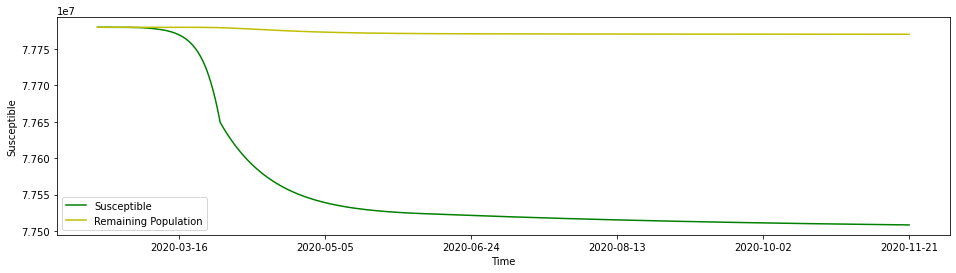

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1280x320 with 0 Axes>

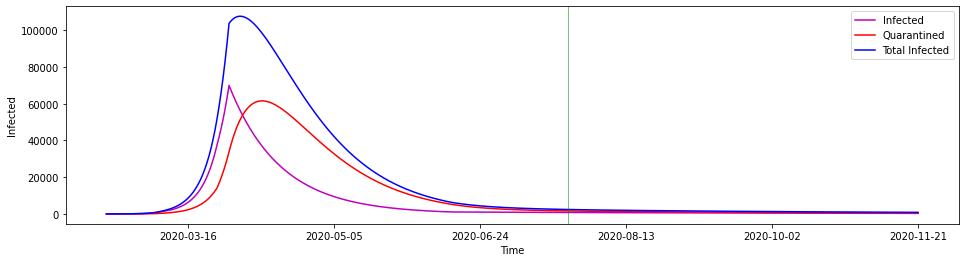

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x320 with 0 Axes>

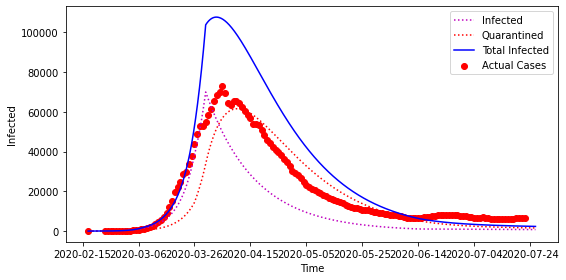

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x320 with 0 Axes>

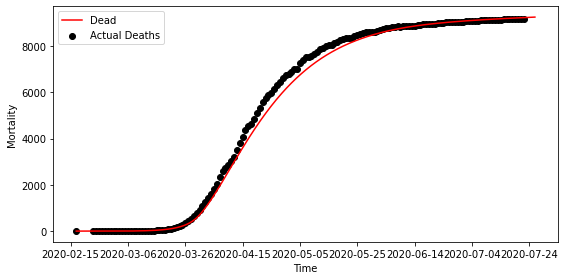

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 480x640 with 0 Axes>

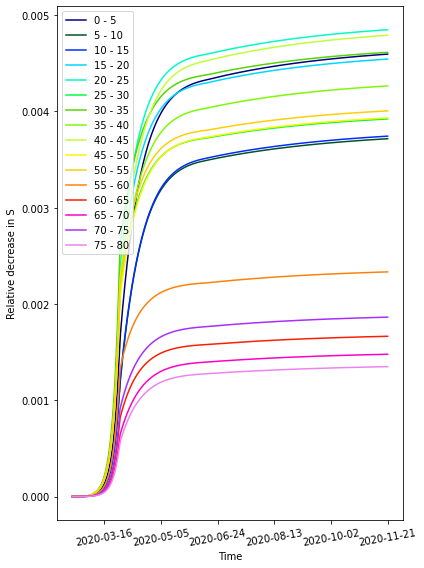

In [ ]:
if not os.path.exists('eps'):
    os.mkdir('eps')

figure(num=1, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
fig, ax = pl.subplots(figsize=(16, 4))
pl.plot(t, S, '-g', label='Susceptible')
pl.plot(t, S + I + Q + R, '-y', label='Remaining Population')
#pl.plot(t, S2, ':g', label='Susceptible 2')
#pl.plot(t, S2 + I2 + Q2 + R2, ':y', label='Remaining Population 2')
ax.xaxis.set_major_formatter(pl.FuncFormatter(datename_))
pl.xticks(rotation=0)
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Susceptible')
pl.savefig('eps/ge-susceptible.eps', format='eps')
pl.show()

figure(num=2, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
fig, ax = pl.subplots(figsize=(16, 4))
pl.plot(t, I, '-m', label='Infected')
#pl.plot(t, I2, '--m', label='Infected 2')
pl.plot(t, Q, '-r', label='Quarantined')
#pl.plot(t, Q2, '--r', label='Quarantined 2')
pl.plot(t, I + Q, '-b', label='Total Infected')
#pl.plot(t, I2 + Q2, '--b', label='Total Infected 2')
#pl.plot(t, F, ':k', label='Dead')
ax.axvline(x=180, color='g', linewidth=.5)
ax.xaxis.set_major_formatter(pl.FuncFormatter(datename_))
pl.xticks(rotation=0)
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infected')
pl.savefig('eps/ge-infected.eps', format='eps')
pl.show()

figure(num=3, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
fig, ax = pl.subplots(figsize=(8, 4))
pl.plot(t[int(0/TS):int(160/TS)], I[int(0/TS):int(160/TS)], ':m', label='Infected')
pl.plot(t[int(0/TS):int(160/TS)], Q[int(0/TS):int(160/TS)], ':r', label='Quarantined')
pl.plot(t[int(0/TS):int(160/TS)], I[int(0/TS):int(160/TS)] + Q[int(0/TS):int(160/TS)], '-b', label='Total Infected')
#pl.plot(t[int(0/TS):int(76/TS)], I2[int(0/TS):int(76/TS)] + Q2[int(0/TS):int(76/TS)], '--b', label='Total Infected 2')
pl.scatter(day[0:], cases[0:], c='r', label='Actual Cases')
ax.xaxis.set_major_formatter(pl.FuncFormatter(datename_))
pl.xticks(rotation=0)
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Infected')
pl.tight_layout()
pl.savefig('eps/ge-infected-fit.eps', format='eps')
pl.show()

figure(num=4, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')
fig, ax = pl.subplots(figsize=(8, 4))
#pl.plot(t, R, '-k', label='Recovered')
#pl.plot(t[0:int(150/TS)], (0.9e4 / (1 + np.exp(-(t - 85)/12)))[0:int(150/TS)], '--r', label='Dead (Logistic)')
pl.scatter(day, deaths, c='k', label='Actual Deaths')
pl.plot(t[0:int(160/TS)], F[0:int(160/TS)], '-r', label='Dead')
ax.xaxis.set_major_formatter(pl.FuncFormatter(datename_))
pl.xticks(rotation=0)
pl.legend(loc=0)
pl.xlabel('Time')
pl.ylabel('Mortality')
pl.tight_layout()
pl.savefig('eps/ge-mortality.eps', format='eps')
pl.show()

#figure(num=5, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
#pl.plot(t, np.sum(Qi[:, 0:4], axis=1), '-r', label='0 - 20')
#pl.plot(t, np.sum(Qi[:, 4:8], axis=1), '-g', label='20 - 40')
#pl.plot(t, np.sum(Qi[:, 8:12], axis=1), '-b', label='40 - 60')
#pl.plot(t, np.sum(Qi[:, 12:16], axis=1), '-k', label='60 - 80')
#pl.plot(t, np.sum(Qi2[:, 0:4], axis=1), '--r', label='0 - 20')
#pl.plot(t, np.sum(Qi2[:, 4:8], axis=1), '--g', label='20 - 40')
#pl.plot(t, np.sum(Qi2[:, 8:12], axis=1), '--b', label='40 - 60')
#pl.plot(t, np.sum(Qi2[:, 12:16], axis=1), '--k', label='60 - 80')
#pl.legend(loc=0)
#pl.xlabel('Time')
#pl.ylabel('Quarantined')
#pl.show()

figure(num=6, figsize=(6, 8), dpi=80, facecolor='w', edgecolor='k')
fig, ax = pl.subplots(figsize=(6, 8))
#Xi = np.cumsum((Ii + Qi), axis=0)
#pl.plot(t[int(50/TS):], (np.sum(Fi[:, 0:4], axis=1) / np.sum(Ni[:, 0:4], axis=1))[int(50/TS):], '-r', label='0 - 20')
#pl.plot(t[int(50/TS):], (np.sum(Fi[:, 4:8], axis=1) / np.sum(Ni[:, 4:8], axis=1))[int(50/TS):], '-g', label='20 - 40')
#pl.plot(t[int(50/TS):], (np.sum(Fi[:, 8:12], axis=1) / np.sum(Ni[:, 8:12], axis=1))[int(50/TS):], '-b', label='40 - 60')
#pl.plot(t[int(50/TS):], (np.sum(Fi[:, 12:16], axis=1) / np.sum(Ni[:, 12:16], axis=1))[int(50/TS):], '-k', label='60 - 80')
#pl.plot(t, (np.sum(Si[:, 0:4], axis=1)[0] - np.sum(Si[:, 0:4], axis=1)) / np.sum(Si[:, 0:4], axis=1)[0], '-r', label='0 - 20')
#pl.plot(t, (np.sum(Si[:, 4:8], axis=1)[0] - np.sum(Si[:, 4:8], axis=1)) / np.sum(Si[:, 4:8], axis=1)[0], '-g', label='20 - 40')
#pl.plot(t, (np.sum(Si[:, 8:12], axis=1)[0] - np.sum(Si[:, 8:12], axis=1)) / np.sum(Si[:, 8:12], axis=1)[0], '-b', label='40 - 60')
#pl.plot(t, (np.sum(Si[:, 12:16], axis=1)[0] - np.sum(Si[:, 12:16], axis=1)) / np.sum(Si[:, 12:16], axis=1)[0], '-k', label='60 - 80')

colormap = pl.cm.gist_ncar
pl.gca().set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 0.9, M)])

for i in range(M):
    pl.plot(t, (np.sum(Si[:, i:i + 1], axis=1)[0] - np.sum(Si[:, i:i + 1], axis=1)) / np.sum(Si[:, i:i + 1], axis=1)[0], label=str(i*5) + ' - ' + str((i + 1) * 5))
ax.xaxis.set_major_formatter(pl.FuncFormatter(datename_))
pl.xticks(rotation=10)
pl.legend(loc=0)
pl.xlabel('Time')
#pl.ylabel('Mortality')
pl.ylabel('Relative decrease in S')
pl.tight_layout()
pl.savefig('eps/ge-relative-S.eps', format='eps')
pl.show()

In [ ]:
!zip -r ./eps.zip ./eps/

  adding: eps/ (stored 0%)
  adding: eps/ge-mortality.eps (deflated 68%)
  adding: eps/ge-susceptible.eps (deflated 67%)
  adding: eps/ge-relative-S.eps (deflated 65%)
  adding: eps/ge-infected.eps (deflated 65%)
  adding: eps/ge-infected-fit.eps (deflated 66%)


##Optimize

In [ ]:
from scipy import optimize

def find_error(b):
    y = spi.odeint(diff_eqs, y0, t, args=(b, delta, gamma, epsilon, mu, C))
    Si, Ii, Qi, Ri, Fi = y[:, 0:M], y[:, M:2*M], y[:, 2*M:3*M], y[:, 3*M:4*M], y[:, 4*M:5*M]
    S, I, Q, R, F = np.sum(Si, axis=1), np.sum(Ii, axis=1), np.sum(Qi, axis=1), np.sum(Ri, axis=1), np.sum(Fi, axis=1)

    error = 0.0
    for i in day:
        d = int((i - first_day) / TS)
        error += ((cases[day == i] - Q[d]) / 100)**2
    return error

In [ ]:
guess = 0.048
sol = optimize.minimize(find_error, guess)
print(sol.x[0])
print(find_error(sol.x[0]))
print(find_error(beta))

0.04845823736880081
[1137756.34345715]
[1550816.13569102]


##Reproductive Ratio

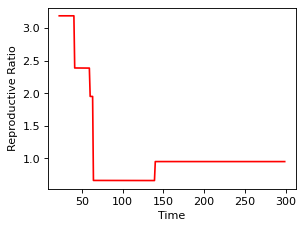

[3.1863319578578553, 3.1863318220590555, 3.1863316476959174, 3.1863314216746286, 3.186331126652968, 3.1863307396471487, 3.1863302301832768, 3.1863295578440622, 3.1863286690126857, 3.186327492551591, 3.186325934067212, 3.1863238682982455, 3.1863211290132494, 3.186317495602749, 3.1863126752844044, 3.1863062794859447, 3.1862977925013283, 3.186286529892696, 3.186271583284725, 2.3856905145009972, 2.3856778822201505, 2.3856626684957165, 2.3856443730456736, 2.3856223968105614, 2.385596022591805, 2.385564391889415, 2.3855264771956075, 2.3854810488558034, 2.3854266354420846, 2.3853614763630873, 2.3852834652068142, 2.3851900820137755, 2.385078312332662, 2.3849445504984526, 2.3847844840977257, 2.3845929560015184, 2.384363799681361, 2.384089642725197, 1.949473108730073, 1.9491932361792719, 1.9488645051878084, 1.948479275079614, 0.9491181396356685, 0.9491120720904999, 0.9491062738570509, 0.9491007269133449, 0.9490954145238539, 0.9490903211467174, 0.9490854323475533, 0.9490807347196765, 0.9490762158

In [ ]:
def xit(X, i, t):
    return X[int((t - first_day) / TS), i]

def FV(t):
    F = np.zeros((2*M, 2*M))
    V = np.zeros((2*M, 2*M))
    
    Ni = Si + Ii + Qi + Ri
    NNi = np.zeros(M)
    for i in range(M):
        NNi[i] = xit(Ni, i, t)


    for i in range(2*M):
        for j in range(2*M):
            if i < M and j < M and i == j:
                V[i, j] = delta(t)[i] + epsilon
            if (i - M) == j:
                V[i, j] = -1 * delta(t)[i - M]
            if i >= M and j >= M and i == j:
                V[i, j] = gamma(t)[i - M] + mu[i - M]
            if i < M and j < M:
                #F[i, j] = beta * C(t)[i, j] * NNi[i] / NNi[j] 
                F[i, j] = beta * C(t)[i, j] * xit(Si, i, t) / (xit(Si, j, t) + xit(Ii, j, t) + xit(Ri, j, t))
    return F, V

def reproductive_ratio(t):
    F, V = FV(t)
    X = np.matmul(F, np.linalg.inv(V))
    return np.max(np.abs(np.linalg.eigvals(X)))

RR0 = []
TT  = range(first_day, last_day)
#TT = np.arange(17.8, 18.2, TS)
for i in TT:
    RR0.append(reproductive_ratio(i))

figure(num=7, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
pl.plot(TT, RR0, '-r', label='R0')
pl.xlabel('Time')
pl.ylabel('Reproductive Ratio')
pl.savefig('eps/ge-R0.eps', format='eps')
pl.show()

print(sorted(set(RR0))[::-1])
print(RR0[TT.index(34)])
print(RR0[TT.index(79)])
print(RR0[TT.index(156)])